# Flugpreis Vorhersage - Kaufen oder Warten?
## Projektarbeit Data Mining
___
### Wintersemester 2021/22
### Gruppe G:
Max Grundmann - s0559326
### Inhalte
1. Exploratory Data Analysis (EDA)
2. Datenvorbereitung
### 3. Modelauswahl
4. Testing
___
Dieses Notebook widmet sich der Auswahl von zwei geeigneten Machine Learning Modellen und deren Hyperparametertuning.
___

#### Benötigte Bibliotheken laden

In [14]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import os
from random import sample
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier

from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

#### Vorbereitete Daten laden

In [2]:
n = 15

dirname = os.getcwd()
filename = os.path.join(dirname, f'../Data/prepped/train_set_n{n}.csv')

try:
    training_data = pd.read_csv(filename, index_col=0)
except FileNotFoundError as e:
    print('Datei konnte nicht gefunden werden.')

Daten in Trainings- und Testdaten aufteilen.
80% Trainingsdaten, 20% Testdaten
Stratify = Yes stellt außerdem sicher, dass das Verhältnis der Klassen in beiden Datensätzen gleich ist.

In [21]:
# Daten in Trainings- und Testdaten aufteilen
y = training_data['buy']
X = training_data.drop(columns=['buy'], axis=1)

X.columns = X.columns.map(str)


for i in range(n):
    X[str(i)] = np.where(X[str(i)].isnull(), X.Price_In_Eur, X[str(i)])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)

In [4]:
X.head()

,Price_In_Eur,last_departure,next_departure,price_of_next_flight,route_FRA-STN,route_STN-FRA,route_STN-SXF,route_SXF-STN,is_last_request,previous_requests,...,flight_weekday_sin,flight_weekday_cos,flight_month_sin,flight_month_cos,flight_day_sin,flight_day_cos,Departure_hour_sin,Departure_hour_cos,days_remaining,Days_Untill_Event
0,208.07,0.0,3.0,0,0,0,0,1,0,0,...,0.974928,-0.222521,1.224647e-16,-1.0,0.085965,0.996298,-0.965926,0.258819,2,4
1,259.07,0.0,3.0,0,0,0,0,1,0,1,...,0.974928,-0.222521,1.224647e-16,-1.0,0.085965,0.996298,-0.965926,0.258819,2,4
2,259.07,0.0,3.0,0,0,0,0,1,0,2,...,0.974928,-0.222521,1.224647e-16,-1.0,0.085965,0.996298,-0.965926,0.258819,1,4
3,259.07,0.0,3.0,0,0,0,0,1,1,3,...,0.974928,-0.222521,1.224647e-16,-1.0,0.085965,0.996298,-0.965926,0.258819,1,4
4,143.86,0.0,9.0,0,0,0,1,0,0,0,...,0.974928,-0.222521,1.224647e-16,-1.0,0.085965,0.996298,-0.707107,0.707107,2,4


#### Auswahl eines ML-Verfahrens

Folgenden Methode dient dem Automatisierten Training und Evaluierung eines ML-Modells. Ziel ist es, eine Baseline für mehrere unterschiedliche Verfahren zu etablieren. Das beste Modell wird anschließend über Hyperparameter Tuning weiter optimiert.

In [27]:
def evaluate_model(model, x_train, y_train, x_test, y_test, fit=True):
    if fit:
        model = model.fit(x_train, y_train)
    
    print('Training Score:', model.score(x_train, y_train))
    
    predicted = pd.DataFrame(model.predict(x_test))
    
    print('Test Score:', metrics.accuracy_score(y_test, predicted))
    
    print(metrics.classification_report(y_test, predicted))
    return model.score(x_train, y_train), metrics.accuracy_score(y_test, predicted)

Die Support Vector Machine wurde im weiteren Vorgehen nicht berücksichtigt, da die Trainingszeiten unverhältnismäßig lag dauern. Das dürfte darin begründet liegen, dass die Trainingskomplexität einer SVM bei O(n^2) liegt und entsprechend stark bzw. schlecht mit der Anzahl an Trainingsdaten skaliert. Entsprechend limitiert vermutlich auch mein Arbeitsspeicher die Berechnung.

In [7]:
list_of_models = [RandomForestClassifier(), 
                # SVC(kernel='linear'), 
                  XGBClassifier(),
                  AdaBoostClassifier(),
                  GradientBoostingClassifier(),
                  tree.DecisionTreeClassifier(max_depth=10), 
                  LogisticRegression(), 
                  BaggingClassifier(),
                  # KNeighborsClassifier(n_neighbors=5), 
                  GaussianNB()]

scores = {}

for model in list_of_models:
    print(model)
    train_acc, test_acc = evaluate_model(model, x_train, y_train, x_test, y_test)
    scores[str(model)[:10]] = {'train_accurary' : train_acc, 'test_accuracy': test_acc}
    print('-------------------------------------------------------------------------------')

RandomForestClassifier()
Training Score: 0.9999103125607258
Test Score: 0.9124663677130045
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     12981
           1       0.90      0.69      0.78      3744

    accuracy                           0.91     16725
   macro avg       0.91      0.83      0.86     16725
weighted avg       0.91      0.91      0.91     16725

-------------------------------------------------------------------------------
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=N

C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training Score: 0.9270392681504955
Test Score: 0.8913004484304933
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     12981
           1       0.85      0.62      0.72      3744

    accuracy                           0.89     16725
   macro avg       0.87      0.80      0.83     16725
weighted avg       0.89      0.89      0.88     16725

-------------------------------------------------------------------------------
AdaBoostClassifier()
Training Score: 0.8283232933227701
Test Score: 0.8206875934230194
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     12981
           1       0.70      0.35      0.47      3744

    accuracy                           0.82     16725
   macro avg       0.77      0.65      0.68     16725
weighted avg       0.81      0.82      0.80     16725

-------------------------------------------------------------------------------
GradientBoostingClassifier()
Trai

C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Score: 0.7964693044739084
Test Score: 0.7932436472346787
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     12981
           1       0.63      0.19      0.29      3744

    accuracy                           0.79     16725
   macro avg       0.72      0.58      0.58     16725
weighted avg       0.77      0.79      0.75     16725

-------------------------------------------------------------------------------
BaggingClassifier()
Training Score: 0.9951269824661056
Test Score: 0.9133632286995516
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     12981
           1       0.89      0.70      0.78      3744

    accuracy                           0.91     16725
   macro avg       0.90      0.84      0.86     16725
weighted avg       0.91      0.91      0.91     16725

-------------------------------------------------------------------------------
GaussianNB()
Training Score: 0.765

In [8]:
results = pd.DataFrame(scores).transpose()
results.rename(columns={'index': 'model'},  inplace=True)
results.head()

,train_accurary,test_accuracy
RandomFore,0.999910,0.912466
XGBClassif,0.927039,0.891300
AdaBoostCl,0.828323,0.820688
GradientBo,0.840162,0.832048
DecisionTr,0.859684,0.842451


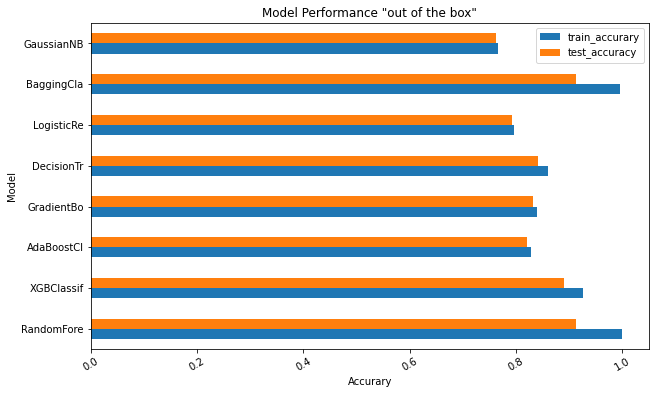

In [9]:
plt.rcParams["figure.figsize"] = [10, 6]

results.plot(kind='barh')
plt.title('Model Performance "out of the box"')
plt.ylabel("Model")
plt.xlabel("Accurary")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig("../Ressources/model_performance_comp.png", edgecolor='white')

### Hyperparameter Tuning eines Random Forest Classifiers

Im einem Vergleich ohne jegliches Hyperparameter Tuning hat der Random Forest Classifier für den Datensatz die höchste Test-Genauigkeit erzielt. Allerdings hat sich bereits dort gezeigt, dass der Classifier ohne weiteres Tuning stark zum overfitting neigt, was an einer Trainingsgenauigkeit von 99% deutlich wird. Für das weitere Tuning wird daher eine K-Fold Cross-Validation mit K=5 durchgeführt.

In [11]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

#### Cross-Validation Baseline

In [29]:
def performCrossValidation(model, x_train, y_train, splits=10):
    print(f'{model} mit splits={splits}')
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=3, random_state=1)
    return cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [9]:
display_scores(performCrossValidation(RandomForestClassifier(), x_train, y_train))

RandomForestClassifier() mit splits=10
Scores: [0.91539611 0.91180867 0.9103139  0.91689088 0.9077728  0.91554559
 0.90956652 0.91150972 0.9142003  0.90536702 0.91076233 0.90792227
 0.90866966 0.91375187 0.91106129 0.9122571  0.90538117 0.91569507
 0.91106129 0.91239348 0.90792227 0.91165919 0.91569507 0.9103139
 0.91270553 0.91255605 0.91180867 0.91345291 0.91195815 0.91314098]
Mean: 0.9116179915370206
Standard deviation: 0.002879008209522955


In [10]:
display_scores(performCrossValidation(XGBClassifier(), x_train, y_train))

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None) mit splits=10
Scores: [0.89820628 0.89147982 0.89058296 0.89506726 0.89536622 0.89566517
 0.89865471 0.88819133 0.88819133 0.8904171  0.8916293  0.8955157
 0.88863976 0.89297459 0.89431988 0.89282511 0.88550075 0.88669656
 0.89282511 0.8914636  0.88535127 0.8916293  0.89835575 0.8857997
 0.89297459 0.89043348 0.8

In [13]:
display_scores(performCrossValidation(BaggingClassifier(), x_train, y_train, 5))

BaggingClassifier() mit splits=5
Scores: [0.90470852 0.90396114 0.90769806 0.90814649 0.90268331 0.9038864
 0.90231689 0.9064275  0.90418535 0.90485089 0.90373692 0.90904335
 0.90455904 0.90500747 0.90746693]
Mean: 0.9052452167469912
Standard deviation: 0.0019697084758584058


In [12]:
display_scores(performCrossValidation(GradientBoostingClassifier(), x_train, y_train, 2))

GradientBoostingClassifier() mit splits=2
Scores: [0.83793722 0.83817154 0.83689088 0.83951688 0.8386846  0.83861999]
Mean: 0.8383035192247625
Standard deviation: 0.0008025740771724184


#### Grid Search für Random Forrest Classfier

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# rf_random = RandomizedSearchCV(estimator = rf, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, 
#                                cv = 3, 
#                                verbose=2, 
#                                random_state=42, 
#                                n_jobs = -1)

# rf_random.fit(x_train, y_train)
# rf_random.best_params_

In [22]:
random_grid = {'n_estimators': [50, 200, 400],
               'max_features': ['auto', 0.25, 0.5, 1.0],
               'max_depth': [4, 8,16],
               'min_samples_split': [2, 5, 10],
            #    'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

rf = RandomForestClassifier(class_weight=classWeight)

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 2, 
                               cv = 2, 
                               verbose=99, 
                               random_state=42,
                               scoring='accuracy',
                               n_jobs = -1,
                               refit=True)

model = rf_random.fit(x_train, y_train)
rf_random.best_params_

Fitting 2 folds for each of 2 candidates, totalling 4 fits


C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\ensemble\_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\

{'n_estimators': 50,
 'min_samples_split': 5,
 'max_features': 1.0,
 'max_depth': 16,
 'bootstrap': True}

In [24]:
model_save_path = '../Models/final_models/random_forest_v1.pkl'
pickle.dump(rf_random, open(model_save_path, 'wb'))

In [25]:
rf_model = pickle.load(open('../Models/final_models/random_forest_v2.pkl', 'rb'))

In [73]:
evaluate_model(rf_model, x_train, y_train, x_test, y_test, fit=False)

Training Score: 0.9706722073573596
Test Score: 0.9727354260089686
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12981
           1       0.92      0.97      0.94      3744

    accuracy                           0.97     16725
   macro avg       0.95      0.97      0.96     16725
weighted avg       0.97      0.97      0.97     16725



(0.9706722073573596, 0.9727354260089686)

C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


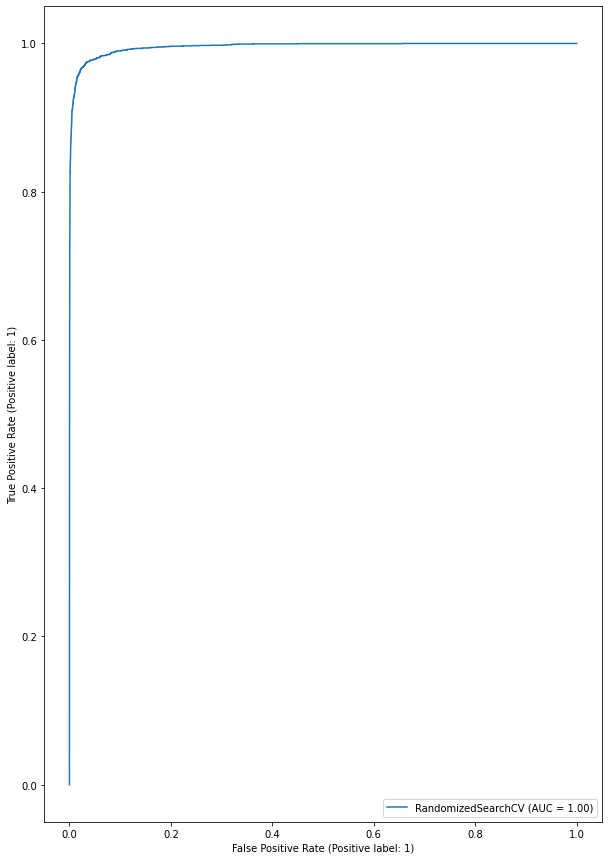

In [74]:
metrics.plot_roc_curve(rf_model, x_test, y_test) 

In [ ]:
display_scores(performCrossValidation(rf_model, x_train, y_train))

In [36]:
rf_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 5,
 'max_features': 0.5,
 'max_depth': 16,
 'bootstrap': False}

In [72]:
new_rf = RandomForestClassifier(n_estimators= 100,
 min_samples_split= 8,
 max_features=0.5,
 max_depth= 32,
 bootstrap= False,
 class_weight=classWeight)
new_rf.fit(x_train, y_train)
evaluate_model(new_rf, x_train, y_train, x_test, y_test, fit=False)

Training Score: 0.9988789070090733
Test Score: 0.9322571001494768
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     12981
           1       0.88      0.81      0.84      3744

    accuracy                           0.93     16725
   macro avg       0.91      0.89      0.90     16725
weighted avg       0.93      0.93      0.93     16725



(0.9988789070090733, 0.9322571001494768)

#### Feature Importance

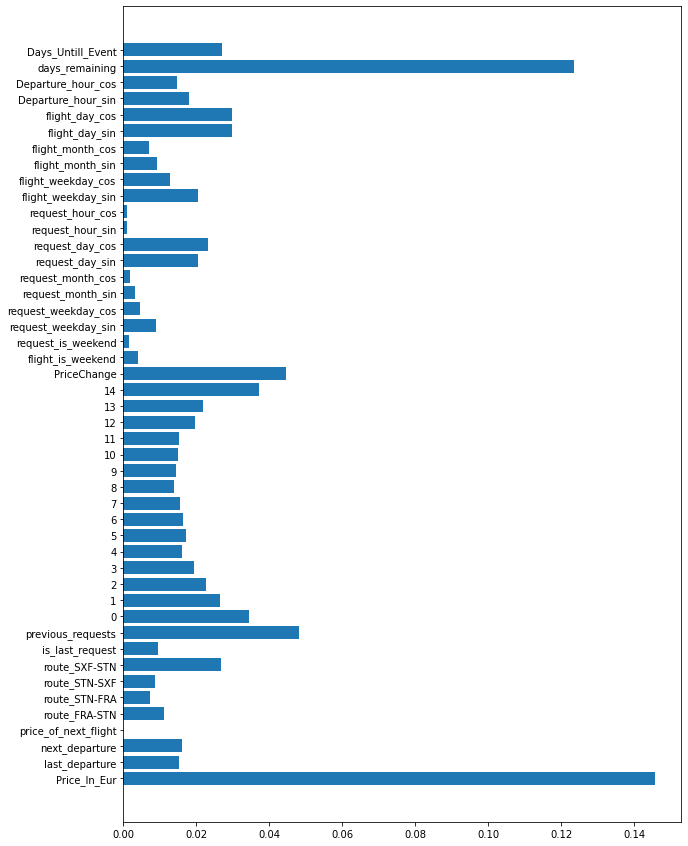

In [58]:
plt.rcParams["figure.figsize"] = [10, 15]
plt.barh(x_train.columns, new_rf.feature_importances_)
plt.savefig('../Ressources/rf_feature_importance.png')

In [71]:
pd.DataFrame(list(zip(new_rf.feature_importances_, x_train.columns))).sort_values(by=[0], ascending=False)

,0,1
0,0.145707,Price_In_Eur
44,0.123657,days_remaining
9,0.048238,previous_requests
25,0.044513,PriceChange
24,0.037178,14
10,0.034459,0
41,0.029855,flight_day_cos
40,0.029790,flight_day_sin
45,0.027065,Days_Untill_Event
7,0.026804,route_SXF-STN


#### Cross Validation mit Hyperparameter Tuning

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

model = RandomForestClassifier(n_estimators= 200, 
                               max_features= 'sqrt')

scores = cross_val_score(model, x_train.drop(['request_is_weekend', 
                                              'request_month_sin', 
                                              'request_month_cos'],1), y_train, scoring='accuracy', cv=cv, n_jobs=-1)

model = model.fit(x_train, y_train)

In [ ]:
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

# Predictions on the test dataset
predicted = pd.DataFrame(model.predict(x_test))
# Probabilities on the test dataset
probs = pd.DataFrame(model.predict_proba(x_test))
print('Test Score:', metrics.accuracy_score(y_test, predicted))

print(metrics.classification_report(y_test, predicted))
print(model.feature_importances_)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=80)

sorted_idx = model.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

___

Konfidenzintervall berechnen? Sinnvoll für Classification?

## 3. Neural Network

Als zweiter Classifier habe ich ein neuronales Netzwerk gewählt. 

In [19]:
from sklearn.utils import compute_class_weight

classWeight = compute_class_weight(class_weight = 'balanced', 
                                   classes=np.unique(y),
                                    y=y)
classWeight = dict(enumerate(classWeight))

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Data Mining/Models/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

early_stopping = EarlyStopping(patience=9999, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=20, min_lr=0.00001, verbose=1)

print(classWeight)

history = model.fit(
    X, 
    y, 
    batch_size = 1024,
    validation_split=0.2,
    epochs=1000, 
    class_weight=classWeight,
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback])
    

Epoch 1/200
2091/2091 [==============================] - 6s 2ms/step - loss: 0.5252 - accuracy: 0.7592 - val_loss: 0.3912 - val_accuracy: 0.8380
Epoch 2/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4859 - accuracy: 0.7803 - val_loss: 0.3771 - val_accuracy: 0.8468
Epoch 3/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4673 - accuracy: 0.7925 - val_loss: 0.3704 - val_accuracy: 0.8504
Epoch 4/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4553 - accuracy: 0.7980 - val_loss: 0.3692 - val_accuracy: 0.8505
Epoch 5/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4476 - accuracy: 0.7992 - val_loss: 0.3663 - val_accuracy: 0.8529
Epoch 6/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4415 - accuracy: 0.8022 - val_loss: 0.3750 - val_accuracy: 0.8529
Epoch 7/200
2091/2091 [==============================] - 5s 2ms/step - loss: 0.4337 - accuracy: 0.8059 - val_loss: 0.3709 - val_ac

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

TypeError: 'History' object is not subscriptable

In [ ]:
pred = model.predict(x_test)

In [ ]:
print(metrics.classification_report(y_test, pred))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## 3. Feature Engineering

In [ ]:
n = 40

dirname = os.getcwd()
filename = os.path.join(dirname, f'../Data/prepped/test_set_n{n}.csv')

try:
    test_data = pd.read_csv(filename, index_col=0)
except FileNotFoundError as e:
    print('Datei konnte nicht gefunden werden.')

In [ ]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                    bool

def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price'] = df['Price'] * 100
    df['Price'] = df['Price'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == True):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100

In [ ]:
model.predict(test_data)

NameError: name 'model' is not defined

In [ ]:
model_quality_evaluation(test_data)